In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5) 
        self.fc1 = nn.Linear(9216, 128)  
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.conv2(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, 2)        
        x = self.dropout1(x) 
        x = torch.flatten(x, 1) 
        x = self.fc1(x)  
        x = F.relu(x)  
        x = self.dropout2(x) 
        x = self.fc2(x) 
        output = F.log_softmax(x, dim=1)  
        return output

In [95]:
# Set Up Data Loaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device

# define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# load datasets
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform) # 60000
test_dataset = datasets.MNIST('../data', train=False, transform=transform)                # 10000

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [96]:
# print information about the training DataLoader
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'Batch {batch_idx + 1}:')
    print(f'Data shape: {data.shape}')
    print(f'Target shape: {target.shape}')
    # print(f'First data sample: {data[0]}')
    # print(f'First target sample: {target[0]}')
    print('---')
    
    if batch_idx == 0:
        break

Batch 1:
Data shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])
---


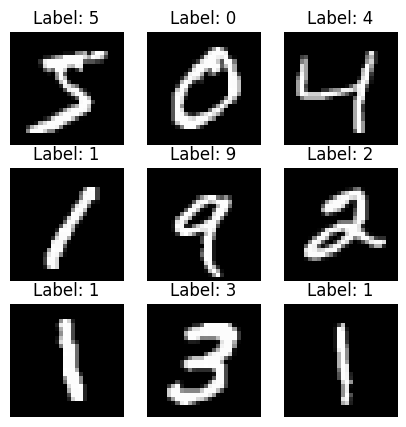

In [97]:
# visualize some samples
def visualize_samples(dataset):
    images, labels = next(iter(torch.utils.data.DataLoader(dataset, batch_size=9)))  # get a batch of images
    images = images.numpy()
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0], cmap='gray')  # display image
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

visualize_samples(train_dataset)

In [98]:
# Define Training and Testing Functions
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()              # zero the gradients
        output = model(data)               # forward pass
        loss = F.nll_loss(output, target)  # calculate loss
        loss.backward()                    # backpropagation
        optimizer.step()                   # update weights
        if batch_idx % 10 == 0:            # log every 10 batches
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)                                             # forward pass
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)                        # get index of max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()            # count correct predictions

    test_loss /= len(test_loader.dataset)                                    # average loss
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [166]:
# Initialize the Model, Optimizer, and Scheduler
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# Run Training and Testing Loops
num_epochs = 14
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()  # update learning rate

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305277
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.382643
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.854491
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.448510
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.359457
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.435641
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.413632
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.273373
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.300853
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.262153
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.149882
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.272143
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.213666
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.235971
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.194852
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.102898
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.213525
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.117306
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.215566
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.195784
Train Epoch: 1 [12800/60000 (